In [1]:
# Import packages
from tensorflow import __version__ as tf_version, float32 as tf_float32, Variable
from tensorflow.keras import Sequential, Model
from tensorflow.keras.backend import variable, dot as k_dot, sigmoid, relu
from tensorflow.keras.layers import Dense, Input, Concatenate, Layer
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.random import set_seed as tf_set_seed
from numpy import __version__ as np_version, unique, array, mean, argmax
from numpy.random import seed as np_seed, choice
from pandas import __version__ as pd_version, read_csv, DataFrame, concat
from sklearn import __version__ as sk_version
from sklearn.preprocessing import normalize

print("tensorflow version:", tf_version)
print("numpy version:", np_version)
print("pandas version:", pd_version)
print("scikit-learn version:", sk_version)

tensorflow version: 2.2.0
numpy version: 1.18.5
pandas version: 1.0.4
scikit-learn version: 0.22.2.post1


In [2]:
# Load cora data
dtf_data = read_csv("https://raw.githubusercontent.com/ngshya/datasets/master/cora/cora_content.csv").sort_values(["paper_id"], ascending=True)
dtf_graph = read_csv("https://raw.githubusercontent.com/ngshya/datasets/master/cora/cora_cites.csv")

# Adjacency matrix
array_papers_id = unique(dtf_data["paper_id"])
dtf_graph["connection"] = 1
dtf_graph_tmp = DataFrame({"cited_paper_id": array_papers_id, "citing_paper_id": array_papers_id, "connection": 0})
dtf_graph = concat((dtf_graph, dtf_graph_tmp)).sort_values(["cited_paper_id", "citing_paper_id"], ascending=True)
dtf_graph = dtf_graph.pivot_table(index="cited_paper_id", columns="citing_paper_id", values="connection", fill_value=0).reset_index(drop=True)
A = array(dtf_graph)
A = normalize(A, norm='l1', axis=1)
A = variable(A, dtype=tf_float32)

# Feature matrix
data = array(dtf_data.iloc[:, 1:1434])

# Labels
labels = array(
    dtf_data["label"].map({
        'Case_Based': 0,
        'Genetic_Algorithms': 1,
        'Neural_Networks': 2,
        'Probabilistic_Methods': 3,
        'Reinforcement_Learning': 4,
        'Rule_Learning': 5,
        'Theory': 6
    })
)

# Check dimensions
print("Features matrix dimension:", data.shape, "| Label array dimension:", labels.shape, "| Adjacency matrix dimension:", A.shape)

Features matrix dimension: (2708, 1433) | Label array dimension: (2708,) | Adjacency matrix dimension: (2708, 2708)


In [3]:
# Training parameters
input_shape = (data.shape[1], )
output_classes = len(unique(labels))
iterations = 50
epochs = 100
batch_size = data.shape[0]
labeled_portion = 0.10

Model: "Model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                45888     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 119       
Total params: 46,535
Trainable params: 46,535
Non-trainable params: 0
_________________________________________________________________


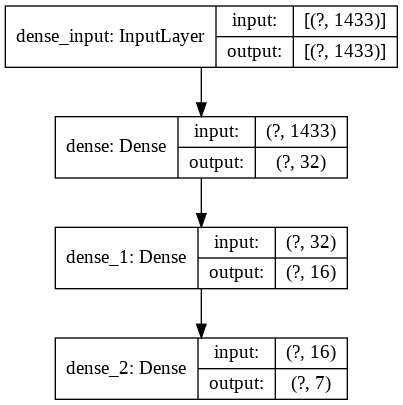

In [4]:
# Model 1: standard sequential neural network

tf_set_seed(1102)
np_seed(1102)

model1 = Sequential([
    Dense(32, input_shape=input_shape, activation='relu'),
    Dense(16, activation='relu'),
    Dense(output_classes, activation='softmax')
], name="Model_1")

model1.save_weights("model1_initial_weights.h5")

model1.summary()
plot_model(model1, 'model1.png', show_shapes=True)

In [5]:
# Testing model 1

tf_set_seed(1102)
np_seed(1102)

acc_model1 = []

for _ in range(iterations):

    mask = choice([True, False], size=data.shape[0], replace=True, p=[labeled_portion, 1-labeled_portion])
    labeled_data = data[mask, :]
    unlabeled_data = data[~mask, :]
    labeled_data_labels = labels[mask]
    unlabeled_data_labels = labels[~mask]

    model1.load_weights("model1_initial_weights.h5")

    model1.compile(
        optimizer='adam',
        loss=SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    model1.fit(labeled_data, labeled_data_labels, epochs=epochs, batch_size=batch_size, verbose=0)

    acc_model1.append(sum(argmax(model1.predict(unlabeled_data, batch_size=batch_size), axis=1) == unlabeled_data_labels) / len(unlabeled_data_labels) * 100)

print("\nAverage accuracy on unlabeled set:", mean(acc_model1), "%")


Average accuracy on unlabeled set: 55.45939381687965 %


Model: "Model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           45888       input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 16)           22944       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 48)           0           dense_3[0][0]                    
                                                                 dense_4[0][0]              

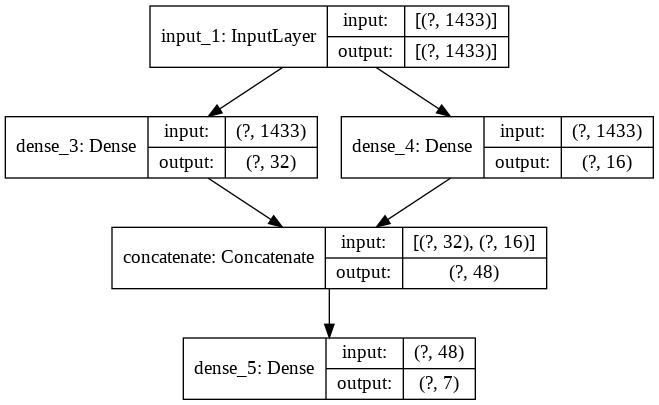

In [6]:
# Model 2: neural network with parallel layers

tf_set_seed(1102)
np_seed(1102)

m2_input_layer = Input(shape=input_shape)
m2_dense_layer_1 = Dense(32, activation='relu')(m2_input_layer)
m2_dense_layer_2 = Dense(16, activation='relu')(m2_input_layer)
m2_merged_layer = Concatenate()([m2_dense_layer_1, m2_dense_layer_2])
m2_final_layer = Dense(output_classes, activation='softmax')(m2_merged_layer)

model2 = Model(inputs=m2_input_layer, outputs=m2_final_layer, name="Model_2")

model2.save_weights("model2_initial_weights.h5")
model2.summary()
plot_model(model2, 'model2.png', show_shapes=True)

In [7]:
# Testing model 2

tf_set_seed(1102)
np_seed(1102)

acc_model2 = []

for _ in range(iterations):

    mask = choice([True, False], size=data.shape[0], replace=True, p=[labeled_portion, 1-labeled_portion])
    labeled_data = data[mask, :]
    unlabeled_data = data[~mask, :]
    labeled_data_labels = labels[mask]
    unlabeled_data_labels = labels[~mask]

    model2.load_weights("model2_initial_weights.h5")

    model2.compile(
        optimizer='adam',
        loss=SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    model2.fit(labeled_data, labeled_data_labels, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=0)

    acc_model2.append(sum(argmax(model2.predict(unlabeled_data, batch_size=batch_size), axis=1) == unlabeled_data_labels) / len(unlabeled_data_labels) * 100)

print("\nAverage accuracy on unlabeled set:", mean(acc_model2), "%")


Average accuracy on unlabeled set: 59.82380909711231 %


In [8]:
# Graph convolutional layer

class GraphConv(Layer):

    def __init__(self, num_outputs, A, activation="sigmoid", **kwargs):
        super(GraphConv, self).__init__(**kwargs)
        self.num_outputs = num_outputs
        self.activation_function = activation
        self.A = Variable(A, trainable=False)

    def build(self, input_shape):
        # Weights
        self.W = self.add_weight( 
            "W",
            shape=[int(input_shape[-1]),
            self.num_outputs]
        )
        # bias
        self.bias = self.add_weight( 
            "bias",
            shape=[self.num_outputs]
        )

    def call(self, input):
        if self.activation_function == 'relu':
            return relu(k_dot(k_dot(self.A, input), self.W) + self.bias)
        else:
            return sigmoid(k_dot(k_dot(self.A, input), self.W) + self.bias)

Model: "Model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 32)           45888       input_2[0][0]                    
__________________________________________________________________________________________________
graph_conv (GraphConv)          (2708, 16)           7356208     input_2[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (2708, 48)           0           dense_6[0][0]                    
                                                                 graph_conv[0][0]           

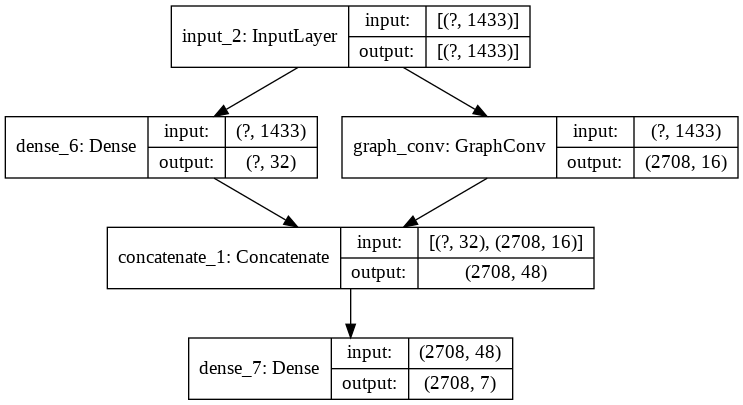

In [9]:
# Model 3: neural network with graph convolutional layer

tf_set_seed(1102)
np_seed(1102)

m3_input_layer = Input(shape=input_shape)
m3_dense_layer = Dense(32, activation='relu')(m3_input_layer)
m3_gc_layer = GraphConv(16, A=A, activation='relu')(m3_input_layer)
m3_merged_layer = Concatenate()([m3_dense_layer, m3_gc_layer])
m3_final_layer = Dense(output_classes, activation='softmax')(m3_merged_layer)
    
model3 = Model(inputs=m3_input_layer, outputs=m3_final_layer, name="Model_3")

model3.save_weights("model3_initial_weights.h5")

model3.summary()
plot_model(model3, 'model3.png', show_shapes=True)

In [10]:
# Testing model 3

tf_set_seed(1102)
np_seed(1102)

acc_model3 = []

for i in range(iterations):

    mask = choice([True, False], size=data.shape[0], replace=True, p=[labeled_portion, 1-labeled_portion])
    unlabeled_data_labels = labels[~mask]
    # Randomize the labels of unlabeled instances
    masked_labels = labels.copy()
    masked_labels[~mask] = choice(range(7), size=sum(~mask), replace=True)

    model3.load_weights("model3_initial_weights.h5")

    model3.compile(
        optimizer='adam',
        loss=lambda y_true, y_pred: SparseCategoricalCrossentropy(from_logits=False)(y_true[mask], y_pred[mask]),
        metrics=['accuracy']
    )

    model3.fit(data, masked_labels, epochs=epochs, batch_size=batch_size, shuffle=False, verbose=0)

    predictions = argmax(model3.predict(data, batch_size=batch_size), axis=1)
    acc_model3.append(sum(predictions[~mask] == unlabeled_data_labels) / len(unlabeled_data_labels) * 100)

print("\nAverage accuracy on unlabeled set:", mean(acc_model3), "%")


Average accuracy on unlabeled set: 62.94568203830694 %
